In [2]:
import tensorflow as tf
import numpy as np
import h5py
from tensorflow import keras
import segmentation_models as sm
import math
import imageio
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from matplotlib import pyplot as plt
import pandas as pd
%env SM_FRAMEWORK=tf.keras
keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.
env: SM_FRAMEWORK=tf.keras


In [6]:
def preprocess(x, y):
        x=np.expand_dims(x,axis=-1) #convert (z,x,y) to (n,x,y,c)
        y=np.expand_dims(y,axis=-1)
        augmented_xs = [] 
        augmented_ys = []
        seq = iaa.Sequential([iaa.size.CropToFixedSize(256,256)])
        for i in range(len(x)):
            segmap = SegmentationMapsOnImage(y[i].astype(np.uint8),shape=x[i].shape)
            x_augmented, y_augmented = seq(image=x[i].astype(np.uint8), segmentation_maps=segmap)
            augmented_xs.append(x_augmented)
            augmented_ys.append(y_augmented.arr)
        return np.stack(augmented_xs), np.stack(augmented_ys)
        

In [7]:
sample_a = h5py.File('../datasets/cremi/train/sample_A_20160501.hdf','r')
sample_a_raw = sample_a['volumes/raw'][:]
sample_a_labels=sample_a['volumes/labels/clefts'][:]

sample_b= h5py.File('../datasets/cremi/train/sample_B_20160501.hdf','r')
sample_b_raw = sample_b['volumes/raw'][:]
sample_b_labels=sample_b['volumes/labels/clefts'][:]

sample_c = h5py.File('../datasets/cremi/train/sample_C_20160501.hdf','r')
sample_c_raw = sample_c['volumes/raw'][:]
sample_c_labels=sample_c['volumes/labels/clefts'][:]

input_raw = np.append(sample_a_raw,sample_b_raw,axis=0)
input_raw = np.append(input_raw,sample_b_raw,axis=0)

input_labels = np.append(sample_a_labels, sample_b_labels,axis=0)
input_labels=np.append(input_labels, sample_b_labels, axis=0)

print(f'Input Raw Shape: {input_raw.shape}')
print(f'Input Labels Shape: {input_labels.shape}')
      
input_labels[input_labels!=np.uint64(-1)] = 1
input_labels[input_labels!=1] = 0

input_raw, input_labels = preprocess(input_raw,input_labels)

print(f'Input Raw Shape: {input_raw.shape}')
print(f'Input Labels Shape: {input_labels.shape}')

Input Raw Shape: (375, 1250, 1250)
Input Labels Shape: (375, 1250, 1250)
Input Raw Shape: (375, 256, 256, 1)
Input Labels Shape: (375, 256, 256, 1)


In [ ]:
resnet152=sm.Unet('resnet152',classes=1,input_shape=(256, 256, 1), encoder_weights=None, activation='sigmoid')
resnet152.summary()

In [ ]:
resnet152.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss=keras.losses.BinaryCrossentropy(),metrics=keras.metrics.MeanIoU(num_classes=2))

In [ ]:
tensor_board = keras.callbacks.TensorBoard(log_dir='model_experiments/cremi_resnet152/tensorboard', write_graph=False, write_images=True,write_steps_per_second=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_experiments/cremi_resnet152/model_weights/model_weights.ckpt',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
callbacks=[tensor_board,model_checkpoint]

In [ ]:
history=resnet152.fit(input_raw, input_labels,batch_size=25, epochs=1000, callbacks=callbacks, validation_split=0.2, validation_freq = 10)

[184.016845703125,
 2.832397699356079,
 0.632430911064148,
 0.5019394159317017,
 0.6231043338775635,
 0.39927420020103455,
 0.3686119019985199,
 0.36146682500839233,
 0.31884443759918213,
 0.42438429594039917,
 0.30146530270576477,
 0.2740892469882965,
 0.28128668665885925,
 0.2468017041683197,
 0.23705053329467773,
 0.2374972254037857,
 0.22374732792377472,
 0.22103726863861084,
 0.2082664668560028,
 0.3547128736972809,
 0.20317015051841736,
 0.1923203021287918,
 0.1830083727836609,
 0.17693102359771729,
 0.16956301033496857,
 0.16359242796897888,
 0.1575053632259369,
 0.15193235874176025,
 0.14624013006687164,
 0.14103390276432037,
 0.13588739931583405,
 0.13063909113407135,
 0.12552829086780548,
 0.12112749367952347,
 0.11651629209518433,
 0.11327379941940308,
 0.10865677893161774,
 0.10499449074268341,
 0.10148245841264725,
 0.09855139255523682,
 0.09426786750555038,
 0.0926259458065033,
 0.08890236169099808,
 0.08557074517011642,
 0.08427516371011734,
 0.08031661808490753,
 0.0787

In [ ]:
tf.saved_model.save(resnet152, "lab/aadi/model_experiments/cremi_resnet152/models/resnet152_cremi")

In [8]:
resnet152_cremi = keras.models.load_model("model_experiments/cremi_resnet152/model_weights/model_weights.ckpt")

2022-01-17 22:09:52.001329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 22:09:52.503062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 86 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-01-17 22:10:02.991083: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summ

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [ ]:
test_data = h5py.File('../datasets/cremi/test/sample_A+_20160601.hdf')
test_raws = test_data['volumes/raw'][:]
rand_ind = np.random.randint(0,len(test_raws))
test_raw = test_raws[rand_ind]
plt.imshow(test_raw)

(1, 256, 256, 1)


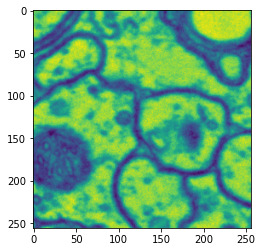

In [4]:
crop = iaa.CropToFixedSize(256,256)
test_raw = crop.augment_image(image=test_raw)
plt.imshow(np.squeeze(test_raw))
test_raw = np.expand_dims(test_raw,axis=0)
test_raw = np.expand_dims(test_raw, axis=-1)
print(test_raw.shape)

In [5]:
test_segmentation = resnet152.predict(test_raw)

NameError: name 'resnet152' is not defined

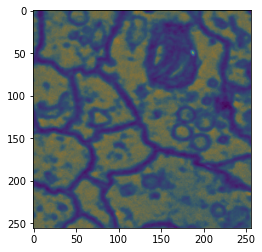

In [29]:
plt.imshow(np.squeeze(test_raw[0]))
plt.imshow(np.squeeze(test_segmentation[0]),alpha=0.5)